In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# 학습 모델 저장을 위한 라이브러리
import pickle

# statsmodels API 불러오기
import statsmodels.api as sm

from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder

In [2]:
# 교차검증 횟수
cv_count = 2

# 교차 검증
kfold = KFold(n_splits=cv_count, shuffle=True, random_state=1)

In [3]:
# 추출: 원본 학습·테스트 데이터 불러오기
df_raw   = pd.read_csv("merged_2018_train.csv")
train_df = df_raw.drop(columns=['ID'])
test_df  = pd.read_csv("merged_2018_test.csv")

# 정의: X·y 분리 (기준년월 제외)
X = train_df.drop(columns=['Segment', '기준년월'])
y = train_df['Segment']

# 추출: 테스트 ID 저장
test_ids = test_df['ID']

# 정의: 테스트 입력 준비 (ID·Segment·기준년월 제외)
test_X = test_df.drop(columns=['ID', 'Segment', '기준년월'], errors='ignore')

# 생성: 타깃 라벨 인코딩
encoder = LabelEncoder()
y_num   = encoder.fit_transform(y)

# 생성: 수치형 입력 스케일링
scaler        = StandardScaler()
X_scaled      = scaler.fit_transform(X)
test_X_scaled = scaler.transform(test_X)

In [4]:
# 교차검증으로 성능 평가
f1_scores  = []
acc_scores = []

for train_idx, val_idx in kfold.split(X_scaled):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_num[train_idx],   y_num[val_idx]
    
    model = XGBClassifier(
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_pred, average='micro'))
    acc_scores.append(accuracy_score(y_val, y_pred))

In [5]:
# 교차검증 결과 출력
print(f'Cross-Validation Micro F1: {np.mean(f1_scores):}')
print(f'Cross-Validation Accuracy: {np.mean(acc_scores):}')

Cross-Validation Micro F1: 0.91157
Cross-Validation Accuracy: 0.91157


### XGBoost

In [6]:
# 전체 데이터로 재학습
final_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    use_label_encoder=False,
    eval_metric='mlogloss'
)
final_model.fit(X_scaled, y_num)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [7]:
# 학습 데이터에 대한 예측 및 성능 확인
y_train_pred = final_model.predict(X_scaled)
print("Train Accuracy:", accuracy_score(y_num, y_train_pred))
print(classification_report(y_num, y_train_pred, target_names=encoder.classes_))

# 테스트 데이터에 대한 예측
test_preds_num = final_model.predict(test_X_scaled)
test_preds     = encoder.inverse_transform(test_preds_num)

# 결과를 ID와 함께 DataFrame으로 정리
submission = pd.DataFrame({
    'ID': test_ids,
    'Segment': test_preds
})

Train Accuracy: 0.9401925
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       162
           B       1.00      1.00      1.00        24
           C       0.86      0.75      0.80     21265
           D       0.83      0.79      0.81     58207
           E       0.96      0.98      0.97    320342

    accuracy                           0.94    400000
   macro avg       0.93      0.90      0.92    400000
weighted avg       0.94      0.94      0.94    400000



In [8]:
# feature 이름 리스트 설정
feature_cols = X.columns

# 절대값 importance 리스트
imp = final_model.feature_importances_

# 상대 중요도(rel_imp) 계산
rel_imp = imp / imp.sum()

# feature importance DataFrame 정리
df_imp = pd.DataFrame({
    'feature': feature_cols,
    'absolute': imp,
    'relative': rel_imp
}).sort_values('relative', ascending=False)

# 상위 15개 중요 피처 확인
print(df_imp.head(15))

                feature  absolute  relative
323       이용금액_오프라인_R3M  0.102193  0.102193
442           이용금액대_ord  0.089706  0.089706
406          정상청구원금_B2M  0.031247  0.031247
38        이용금액_R3M_신용체크  0.027894  0.027894
419  연속유실적개월수_기본_24M_카드  0.025506  0.025506
432              미이용_CA  0.025152  0.025152
402          정상청구원금_B0M  0.019929  0.019929
148      최대이용금액_체크_R12M  0.017825  0.017825
147      최대이용금액_CA_R12M  0.011725  0.011725
440              미이용_할부  0.010065  0.010065
125        이용건수_신용_R12M  0.008855  0.008855
327       이용금액_오프라인_B0M  0.007983  0.007983
8               입회일자_신용  0.007561  0.007561
140        이용금액_체크_R12M  0.007238  0.007238
203         이용금액_체크_R3M  0.006331  0.006331


In [9]:
# 상대 중요도가 0.01 이상인 특성 목록 생성
important_features = df_imp.loc[df_imp['relative'] >= 0.01, 'feature'].tolist()

# 중요 특성 목록 확인
print("상대 중요도 ≥ 0.01인 특성들:", important_features)

상대 중요도 ≥ 0.01인 특성들: ['이용금액_오프라인_R3M', '이용금액대_ord', '정상청구원금_B2M', '이용금액_R3M_신용체크', '연속유실적개월수_기본_24M_카드', '미이용_CA', '정상청구원금_B0M', '최대이용금액_체크_R12M', '최대이용금액_CA_R12M', '미이용_할부']


- 임계치(threshold) 0.01을 쓴다는 것은, 상대 중요도(relative importance)가 1% 이상인 피처만 선택하겠다는 의미
- 개별 피처가 모델 예측에 기여하는 비율이 1% 이상이면 “의미 있는 변수”로 간주

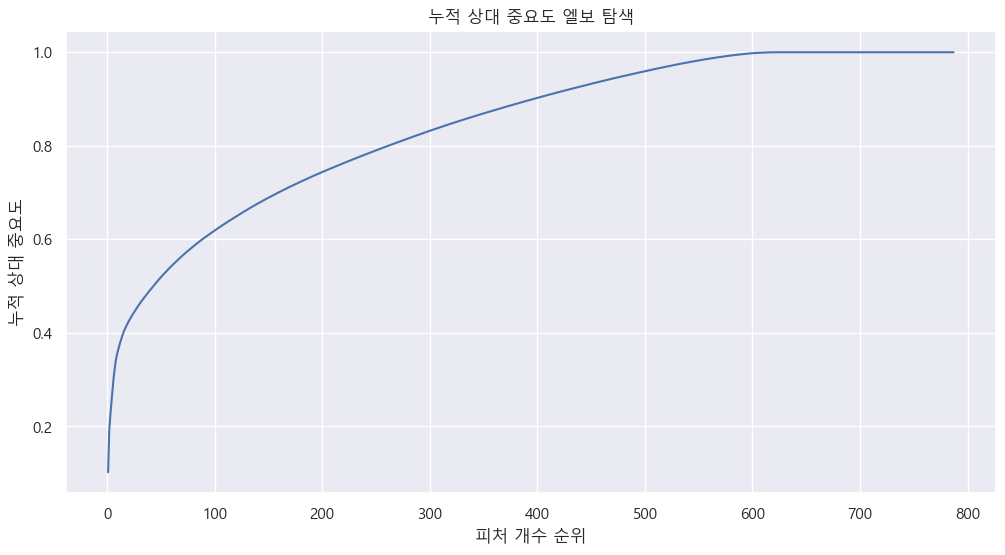

In [10]:
# 누적 상대 중요도 추가
df_imp['cumulative'] = df_imp['relative'].cumsum()

# 누적 그래프 그리기
plt.plot(range(1, len(df_imp)+1), df_imp['cumulative'])
plt.xlabel('피처 개수 순위')
plt.ylabel('누적 상대 중요도')
plt.title('누적 상대 중요도 엘보 탐색')
plt.grid(True)
plt.show()

In [11]:
# 누적 상대 중요도(cumulative)를 가진 DataFrame df_imp 준비
# x(피처 순위), y(누적 중요도) 배열 생성
x = np.arange(1, len(df_imp) + 1)
y = df_imp['cumulative'].values

# 직선 양 끝점 (1, y[0])와 (N, y[-1]) 정의
x1, y1 = x[0], y[0]
x2, y2 = x[-1], y[-1]

# 각 점에서 직선까지의 거리(distance) 배열 구하기
# distance = |(y2−y1)*x − (x2−x1)*y + x2*y1 − y2*x1| / sqrt((y2−y1)^2 + (x2−x1)^2)
distances = np.abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1) \
            / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

# 최대 거리 기준 엘보 지점 인덱스(0-based)와 개수(1-based) 계산
elbow_idx   = np.argmax(distances)
elbow_count = elbow_idx + 1

# 엘보 지점 개수 및 해당 개수만큼의 피처 목록 확인
print(f"엘보 지점 피처 개수: {elbow_count}")
elbow_features = df_imp.head(elbow_count)['feature'].tolist()
print("선택된 피처 목록:", elbow_features)

엘보 지점 피처 개수: 167
선택된 피처 목록: ['이용금액_오프라인_R3M', '이용금액대_ord', '정상청구원금_B2M', '이용금액_R3M_신용체크', '연속유실적개월수_기본_24M_카드', '미이용_CA', '정상청구원금_B0M', '최대이용금액_체크_R12M', '최대이용금액_CA_R12M', '미이용_할부', '이용건수_신용_R12M', '이용금액_오프라인_B0M', '입회일자_신용', '이용금액_체크_R12M', '이용금액_체크_R3M', '최대이용금액_일시불_R12M', '이용금액_체크_R6M', '월상환론한도금액', '입회경과개월수_신용', '이용금액_일시불_R12M', '이용건수_CA_R12M', '이용개월수_신용_R12M', '이용건수_오프라인_R6M', '강제한도감액금액_R12M', '평잔_카드론_3M', '카드이용한도금액_B2M', '일시상환론한도금액', '경과일수_CA', '이용개월수_신용_R6M', '이용금액_CA_R6M', '평잔_일시불_6M', '최대이용금액_할부_무이자_R12M', '변동률_RVCA평잔', '증감율_이용금액_일시불_분기', '이용건수_일시불_B0M', '카드이용한도금액_B1M', '이용금액_CA_R12M', '할부금액_6M_R12M', '이용개월수_CA_R3M', '이용개월수_체크_R12M', '한도증액횟수_R12M', '이용금액_오프라인_R6M', '평잔_카드론_6M', '이용건수_신판_B0M', '최대이용금액_할부_R12M', 'OS구분_Android', '연체입금원금_B2M', '이용개월수_CA_R12M', '연체입금원금_B0M', '이용금액_할부_무이자_R12M', '이용개월수_CA_R6M', '소지카드수_유효_신용', '한도증액후경과월', '수신거부여부_메일', '강제한도감액횟수_R12M', '이용금액_할부_R12M', '소지카드수_이용가능_신용', 'CA이자율_할인전', '_2순위업종_이용금액', '이용메뉴건수_ARS_B0M', '이용후경과월_신판', '증감율_이용금액_신판_분기', '이용건수_신판

- 최대 거리 방식(kneedle)으로 전체 축(1~전체 피처 개수)에 대해 엘보를 찾으면, 곡선이 점점 완만해지는 진짜 ‘첫 번째’ 꺾임이 아니라, 전체 모양에서 선분과의 거리 차이가 최대인 지점을 가리키게 되는데 그게 167번째 피처임

In [12]:
# ID·Segment와 엘보 지점 기준으로 선택된 피처만 추출해 저장
save_cols = ['ID', 'Segment'] + elbow_features
df_raw[save_cols].to_csv(
    '병합_selected_features.csv',
    index=False,
    encoding='utf-8-sig'
)